In [1]:
from multi_path_base import *
#%matplotlib tk 
import os
import datetime as dtM
os.chdir('/Users/alhaddwt/Waleed Dropbox/Waleed Al-Haddad/GitLab/wind-power/python_code')
forecast_with_data=np.load('forecast_with_data.npy')
cwd = os.getcwd()
os.chdir(cwd+'/CI_FIG')
print('path changed to ' + cwd+'/CI_FIG')

path changed to /Users/alhaddwt/Waleed Dropbox/Waleed Al-Haddad/GitLab/wind-power/python_code/CI_FIG


In [68]:
#cleaning data
interpolation_points=1000
forecast_data_inter= np.zeros((3,forecast_with_data.shape[0], interpolation_points ))
x = np.arange(1,72+1,1)
xnew = np.linspace(0,72,interpolation_points)
counter=0
i=0;j=0
while j< forecast_with_data.shape[0]: #fix redundant indicies
    
    y1=forecast_with_data[j,:,1]
    y2=forecast_with_data[j,:,2]
    inter_1=interpolate.interp1d(x, y1, fill_value='extrapolate')
    inter_2=interpolate.interp1d(x, y2, fill_value='extrapolate')
    p=inter_1(xnew)
    d=inter_2(xnew)
    
    if  sum(1*np.isnan(p))==0 and \
        sum(1*np.isnan(d))==0 and \
        np.max(p)<=1 and \
        np.min(p)>=0 and \
        np.max(d)<=1 and \
        np.min(d)>=0:
        
        forecast_data_inter[0,i,:]= p
        forecast_data_inter[1,i,:]= d
        forecast_data_inter[2,i,0]= forecast_with_data[j,0,0]
        i+=1
    j+=1
n_paths=i
print('paths left', i)

paths left 1193


In [3]:
np.isnan(forecast_data_inter).any() #check that there are non nans left

False

In [4]:
(np.max(forecast_data_inter[0,:,:])>1).any()

False

In [5]:
(np.max(forecast_data_inter[1,:,:])>1).any()

False

In [6]:
(np.min(forecast_data_inter[0,:,:])<0).any()

False

In [7]:
(np.min(forecast_data_inter[1,:,:])<0).any()

False

In [105]:
factor_array=np.zeros(n_paths)
k=0;
N=interpolation_points
dN=1/N;
theta=12.3;
theta_array=np.ones((n_paths,interpolation_points))*theta;
X_zero_drift_fixed= np.zeros((n_paths,interpolation_points));
delta=0.1;
while k < n_paths: #n_paths:
    p=forecast_data_inter[0,k,:] #obtain cleansed forecast
    X_zero_drift_raw= p[:-1] + np.diff(p)*N/theta
    #plt.plot(X_zero_drift_raw, 'r');
    
    counter=1
    while counter != 0:
        counter=0
        if factor_array[k]>15:
            break;
        for i in range(0,interpolation_points-1):
            if X_zero_drift_raw[i] < delta:
                g= (delta - X_zero_drift_raw[i] )**2
                if p[i]<0 or p[i]>1:
                    print('WARNING at k=' +str(k) + ' p='+str(p[i]))
                f=  -1*factor_array[k]*g*np.log( min(p[i], 1-p[i]) + 1e-18 ) +1
                theta_array[k,i] = theta_array[k,i]*f
                
            if X_zero_drift_raw[i] > 1 - delta:
                g= ( (1-delta) - X_zero_drift_raw[i]  )**2
                f=  -1*factor_array[k]*g*np.log( min(p[i], 1-p[i]) + 1e-18 ) +1
                theta_array[k,i] = theta_array[k,i]*f

        for j in range(0,interpolation_points-1):
            X_zero_drift_fixed[k,j]= p[j]+ (p[j+1]-p[j])/(dN*theta_array[k,j]);
        
        if max(X_zero_drift_fixed[k,:])>1:
            counter+=1
        if min(X_zero_drift_fixed[k,:])<0:
            counter+=1
        
        if counter != 0:
            factor_array[k] += 0.1
            #print(factor_array[k] )
        #print( counter, factor_array[k] )
    #plt.plot(xnew,X_zero_drift_fixed[k,:])
    k+=1

In [106]:
for k in range(0,n_paths):
    plt.plot(xnew,X_zero_drift_fixed[k,:])

In [110]:
counter=0
for k in range(0,n_paths):
    if max(X_zero_drift_fixed[k,:])>1 == True:
        counter +=1
    if min(X_zero_drift_fixed[k,:])<0 == True:
        counter +=1
counter

0

In [108]:
fig=plt.figure()
fig.clf()
plt.plot(factor_array,'o')
plt.savefig('factor_array.pdf')

In [109]:
plt.plot(theta_array, 'o')
plt.ylim((12,15000));

In [76]:
def gen_X_normal_euler_DT_modified(X0,disct,real,forecast):
    p=forecast
    N=disct.N
    M=disct.M
    X0=p[0]
    theta=real.mu
    alpha=real.sigma
    X=np.zeros((M,N))
    #X_zero_drift=np.zeros(N)
    dN=1/N
    i=0
    j=0
    while j < M:
        X[j,0]=X0
        a=0
        b=0
        dW=np.sqrt(dN)*np.random.normal(0, 1, N)
        i=0
        while i<N-1:
  
            b=  2*alpha*theta[i]*p[i]*(1-p[i])*X[j,i]*(1-X[j,i])
            a= - theta[i]*(X[j,i]-p[i]) + (p[i+1]-p[i])/(dN)
            if b<0:
                print('negative b')
            
            X[j,i+1]= X[j,i] + a*dN+ np.sqrt(b)*dW[i]

            if X[j,i+1] >1:
                X[j,i+1]=X[j,i];
            if X[j,i+1] <0:
                X[j,i+1]=X[j,i];
            #X_zero_drift[i]= p[i]+ (p[i+1]-p[i])/(dN*theta[i]);

            i+=1
        j+=1
    return( X )

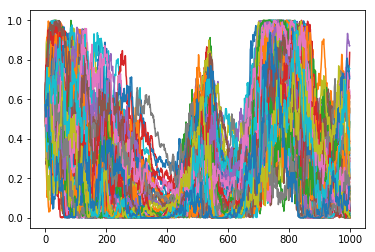

In [78]:
p=forecast_data_inter[0,1192,:] #obtain cleansed forecast
d=forecast_data_inter[1,1192,:]
dt=1
M_test=100
    
theta_const= np.zeros_like(theta_array)+12.3
    
real_1 = real(theta_const[k,:], 2.2) #theta_array

disct_temp = disct(N,dt,M_test)
X=gen_X_normal_euler_DT_modified(X0=p[0],disct=disct_temp,real=real_1,forecast=p)
plt.plot(p)
for i in range(0,M_test):
    plt.plot(X[i,:])

1193

In [111]:
#%%capture

N=interpolation_points
q975=np.zeros((N))
q025=np.zeros((N))
q95=np.zeros((N))
q05=np.zeros((N))
q50=np.zeros((N))
q75=np.zeros((N))
q25=np.zeros((N))

xnew = np.linspace(0,72,interpolation_points)


for k in range(1064,1067): #n_paths  
    p=forecast_data_inter[0,k,:] #obtain cleansed forecast
    d=forecast_data_inter[1,k,:]
    dt=1
    M_test=200
    
    theta_const= np.zeros_like(theta_array)+12.3
    
    real_1 = real(theta_array[k,:], 2.2) #theta_array

    disct_temp = disct(N,dt,M_test)
    
    X = np.empty((M_test,N));
    X= gen_X_normal_euler_DT_modified(X0=p[0],disct=disct_temp,real=real_1,forecast=p)
    plt.plot(X[0,:])
    for i in range(0,N):
        q975[i]=np.quantile(X[:,i], 0.975)
        q025[i]=np.quantile(X[:,i], 0.025)

        q95[i]=np.quantile(X[:,i], 0.95)
        q05[i]=np.quantile(X[:,i], 0.05)

        q50[i]=np.quantile(X[:,i], 0.5)

        q75[i]=np.quantile(X[:,i], 0.75)
        q25[i]=np.quantile(X[:,i], 0.25)
        
    fig=plt.figure(2,figsize=(10, 4))
    fig.clf()

    plt.xlim(1, 73)
    plt.ylim(-0.1, 1.1)

    plt.fill_between(xnew, q75,q25,color='k',alpha=0.2, label='90% CI')
    plt.fill_between(xnew, q95,q05,color='k',alpha=0.5, label='50% CI')

    #plt.plot(xnew,np.mean(normal_X_derivative_tracking_Euler, axis=0),'c-', label='Mean')

    #plt.plot(xnew,q50,'y-', label='Median')
    dt_object = dtM.datetime.fromtimestamp(forecast_data_inter[2,k,0])
    plt.plot(xnew,p, 'r-', label='forecast',linewidth=3)
    plt.plot(xnew,X_zero_drift_fixed[k,:], 'y-', label='Mean Stationarity Line',linewidth=1)
    plt.plot(xnew,d , 'm-', label='Actual production',linewidth=3)
    plt.title('Forecast Confidence Intervals $\\delta=0.1, \ d \\kappa=0.1$ \n {:%d, %b %Y (%H:%M)}'.format(dt_object))#,fontsize=24

    plt.xlabel('Time [hr]')
    plt.ylabel('Power')
    plt.legend( prop={'size': 6})
    plt.savefig('72hr_forecast_CI_'+ str(k)+'.pdf')
    
    fig= plt.figure(2,figsize=(10, 4))
    fig.clf()

    plt.xlim(1, 7)
    plt.ylim(-0.1, 1.1)

    plt.fill_between(xnew, q75,q25,color='k',alpha=0.2, label='90% CI')
    plt.fill_between(xnew, q95,q05,color='k',alpha=0.5, label='50% CI')

    #plt.plot(xnew,np.mean(normal_X_derivative_tracking_Euler, axis=0),'c-', label='Mean')

    #plt.plot(xnew,q50,'y-', label='Median')

    plt.plot(xnew,p, 'r-', label='forecast',linewidth=3)
    plt.plot(xnew,d , 'm-', label='Actual production',linewidth=3)
    
    plt.plot(xnew,X_zero_drift_fixed[k,:], 'y-', label='Mean Stationarity Line',linewidth=1)

    plt.title('Forecast Confidence Intervals \n {:%d, %b %Y (%H:%M)}'.format(dt_object)) #,fontsize=10
    plt.xlabel('Time [hr]')
    plt.ylabel('Power')
    plt.legend( prop={'size': 6})
    plt.xlim(1, 7)
    plt.ylim(0, 1)
    plt.savefig('6hr_forecast_CI_'+ str(k)+'.pdf')
    